In [0]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow.keras
from tensorflow.keras.layers import Flatten, Dense, Dropout , Conv2D , MaxPooling2D , Activation
from tensorflow.keras import layers
from tensorflow.keras.models import Model , Sequential

In [0]:
dataset,info=tfds.load("oxford_flowers102",with_info=True)

In [0]:
def normalize(input_image):
  input_image = tf.cast(input_image, tf.float32) / 255.0
  return input_image

In [0]:
@tf.function
def load_image_train(datapoint):
  #for inception 299 while 224 for mobilenet
  input_image = tf.image.resize(datapoint['image'], (224, 224))
  label=datapoint['label']
  input_image= normalize(input_image)
  return input_image , label

In [0]:
def load_image_test(datapoint):
  input_image = tf.image.resize(datapoint['image'], (224,224))
  label=datapoint['label']
  input_image = normalize(input_image)

  return input_image,label

In [0]:
TRAIN_LENGTH = info.splits['test'].num_examples
BATCH_SIZE = 128
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE
val_steps=1020//BATCH_SIZE

In [0]:
train = dataset['test'].map(load_image_train, num_parallel_calls=tf.data.experimental.AUTOTUNE)
valid=dataset['validation'].map(load_image_train,num_parallel_calls=tf.data.experimental.AUTOTUNE)
test = dataset['train'].map(load_image_test)

In [0]:
train_dataset = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_dataset = test.batch(BATCH_SIZE)
val_dataset=valid.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
val_dataset =val_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [0]:
def display(display_list):
  plt.figure(figsize=(5, 5))
  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

40


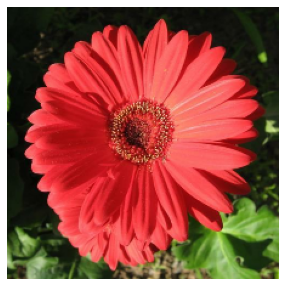

In [0]:
for image,label in train.take(1):
  sample_image = image
  print(label.numpy())
  display([sample_image])

In [0]:
train_dataset

<DatasetV1Adapter shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int64)>

In [0]:
image_batch, label_batch = next(iter(train_dataset))

In [0]:
def show_batch(image_batch, label_batch):
  plt.figure(figsize=(10,10))
  for n in range(16):
      ax = plt.subplot(4,4,n+1)
      plt.imshow(image_batch[n])
      plt.title(label_batch[n])
      plt.axis('off')

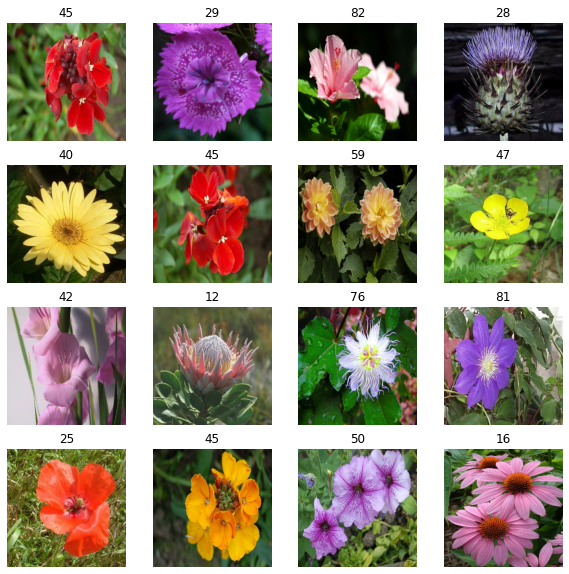

In [0]:
show_batch(image_batch.numpy(), label_batch.numpy())

In [0]:
def visu(history,epo):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs_range = range(epo)

  plt.figure(figsize=(8, 8))
  plt.subplot(1, 2, 1)
  plt.plot(epochs_range, acc, label='Training Accuracy')
  plt.plot(epochs_range, val_acc, label='Validation Accuracy')
  plt.legend(loc='lower right')
  plt.title('Training and Validation Accuracy')

  plt.subplot(1, 2, 2)
  plt.plot(epochs_range, loss, label='Training Loss')
  plt.plot(epochs_range, val_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.title('Training and Validation Loss')
  plt.show()

In [0]:
model = tf.keras.applications.MobileNetV2(
 input_shape=(224,224, 3),
 include_top=False, weights='imagenet', pooling='avg')
model.trainable = False
# Add a new layer for multiclass classification
new_output = tf.keras.layers.Dense(
 102, activation='softmax')
nnew_model = tf.keras.Sequential([model, new_output])
nnew_model.compile(
 loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
 optimizer='adam',
 metrics=['accuracy'])
# Train the classification layer
his=nnew_model.fit(train_dataset, epochs=80,
 steps_per_epoch=STEPS_PER_EPOCH,validation_data=val_dataset,validation_steps=val_steps)

Epoch 1/80
48/48 [==============================] - 7s 139ms/step - loss: 4.4800 - accuracy: 0.2235 - val_loss: 4.4695 - val_accuracy: 0.2065
Epoch 2/80
48/48 [==============================] - 6s 123ms/step - loss: 4.2377 - accuracy: 0.4740 - val_loss: 4.3418 - val_accuracy: 0.3449
Epoch 3/80
48/48 [==============================] - 6s 121ms/step - loss: 4.1207 - accuracy: 0.5791 - val_loss: 4.2723 - val_accuracy: 0.4152
Epoch 4/80
48/48 [==============================] - 6s 121ms/step - loss: 4.0719 - accuracy: 0.6077 - val_loss: 4.2269 - val_accuracy: 0.4487
Epoch 5/80
48/48 [==============================] - 6s 121ms/step - loss: 4.0384 - accuracy: 0.6374 - val_loss: 4.2104 - val_accuracy: 0.4676
Epoch 6/80
48/48 [==============================] - 6s 120ms/step - loss: 4.0084 - accuracy: 0.6753 - val_loss: 4.1667 - val_accuracy: 0.5123
Epoch 7/80
48/48 [==============================] - 6s 120ms/step - loss: 3.9790 - accuracy: 0.7014 - val_loss: 4.1493 - val_accuracy: 0.5246
Epoch 

In [0]:
nnew_model.save('finemodel.h5') 

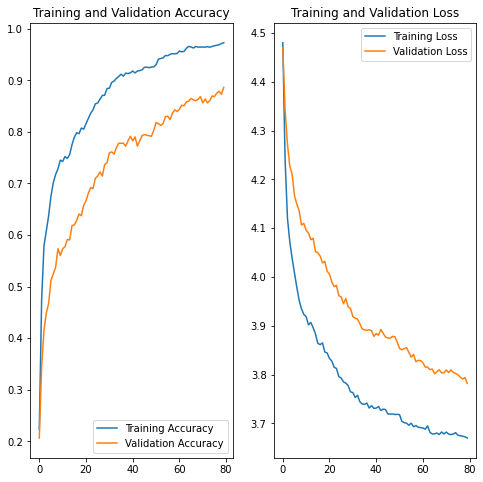

In [0]:
visu(his,80)

In [0]:
nnew_model.evaluate(train_dataset,steps=STEPS_PER_EPOCH)
testset_eval=nnew_model.evaluate(test_dataset,steps=val_steps)


7/7 [==============================] - 2s 241ms/step - loss: 3.8267 - accuracy: 0.8393


In [0]:
np.argmax(nnew_model.predict(test_dataset,steps=val_steps),axis=1)

array([ 72,  87,  70,  51,  48,  87,  42,  58,  40,  29,  40,  60,  59,
        95,  87,  23,  91,  70,  50,  87,  58,  79,  24,  20,  64,  89,
        40, 100,  62,  95,  16,  81,  87,  41,  26,  42,  45,  67,   1,
        61,  10,  54,  39,  19,   7,  12,  72,  29,  11,  11,  42,  26,
        43,  98,  63,  87,  75,  75,  89,  15,  55,  72,  36,  78,   3,
        73,  70,  79,  30,  95,  57,  73,  25,  20,   5,  53,  90,  55,
        23,   0,  92,  28,  16,  81,  63,  21,  52,  79,   8,  28,  12,
        50,  25,  55,  22,  96,  87,  36,  57,  41,  60,  95,  37,  98,
         1,  16,  10,  95,  47,  43,  69,  34,  83,  39,  89,  95,  39,
        73,  59,  36,  52,  67,   6,  21,  60,  81,  73,  12,  34,  11,
        43,  22,  46,  43,  52,  23,  20,  65,  94,  32,  50,  53,  56,
         3,  66,  77,  75,   8,  86,  59,  58,  46,  53,  81,  77,  90,
        88,  15,  50,  16,   3,  33,  77,  46,  39,  16,  71,  27,  41,
        93,  36,  99,  93,  28,  79,  94,  82,  29,  50,  28,  7

In [0]:
model2 = Sequential()
model2.add(Conv2D(32, (3, 3), input_shape=(224,224, 3)))

model2.add(Activation('relu'))
model2.add(MaxPooling2D(pool_size=(2, 2)))

model2.add(Conv2D(64, (3, 3)))
model2.add(Activation('relu'))
model2.add(MaxPooling2D(pool_size=(2, 2)))

model2.add(Flatten())  # go from 3D to 1D

model2.add(Dropout(0.5))  # dropout to avoid over-fitting from: https://www.cs.toronto.edu/~hinton/absps/JMLRdropout.pdf
model2.add(Dense(102))  # fully connected output layer
model2.add(Activation('softmax'))  # softmax the output within the range of (0 to 1) for prediction capabilities
model2.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True),
              optimizer='adam',  #  optimization function with an adaptable learning rate
              metrics=['accuracy']) 

In [0]:
hist=model2.fit(train_dataset, epochs=50,
 steps_per_epoch=STEPS_PER_EPOCH,validation_data=val_dataset,validation_steps=STEPS_PER_EPOCH)

Epoch 1/50
48/48 [==============================] - 13s 275ms/step - loss: 4.5661 - accuracy: 0.0757 - val_loss: 4.5987 - val_accuracy: 0.0412
Epoch 2/50
48/48 [==============================] - 13s 262ms/step - loss: 4.5192 - accuracy: 0.1276 - val_loss: 4.5886 - val_accuracy: 0.0539
Epoch 3/50
48/48 [==============================] - 12s 258ms/step - loss: 4.4945 - accuracy: 0.1526 - val_loss: 4.5835 - val_accuracy: 0.0559
Epoch 4/50
48/48 [==============================] - 12s 255ms/step - loss: 4.4705 - accuracy: 0.1676 - val_loss: 4.5734 - val_accuracy: 0.0696
Epoch 5/50
48/48 [==============================] - 12s 256ms/step - loss: 4.4920 - accuracy: 0.1505 - val_loss: 4.5945 - val_accuracy: 0.0471
Epoch 6/50
48/48 [==============================] - 12s 255ms/step - loss: 4.4774 - accuracy: 0.1687 - val_loss: 4.5779 - val_accuracy: 0.0647
Epoch 7/50
48/48 [==============================] - 12s 256ms/step - loss: 4.4626 - accuracy: 0.1799 - val_loss: 4.5815 - val_accuracy: 0.0598

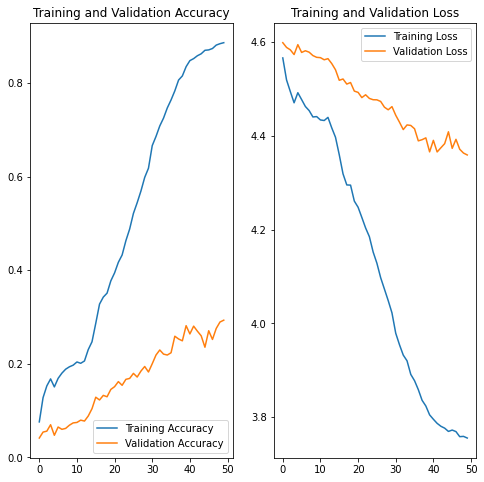

In [0]:
visu(hist,50)